<a href="https://colab.research.google.com/github/m-mejiap/TopicosAvanzadosEnAnalitica/blob/main/Proyecto%20Grafos/P2-AeropuertosBrasil-Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tópicos Avanzados En Analítica - Módulo 2: Grafos.
# Proyecto: Análisis de Aeropuertos en Brasil.

## Descarga e importar librerias:

In [1]:
!pip install torch-geometric
!pip install node2vec
!pip install optuna

In [2]:
import optuna
import numpy as np
import pandas as pd
import networkx as nx
from sklearn import svm
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Importar la base de datos:
Vamos a usar la base de datos de aeropuerts de Basil de torch_geometric.datasets: "The Airports dataset from the “struc2vec: Learning Node Representations from Structural Identity” paper, where nodes denote airports and labels correspond to activity levels. Features are given by one-hot encoded node identifiers, as described in the “GraLSP: Graph Neural Networks with Local Structural Patterns” paper.

In [3]:
from torch_geometric.datasets import Airports
dataset = Airports(root = '.', name = 'Brazil')
dataset

BrazilAirports()

In [4]:
data = dataset[0]
data

Data(x=[131, 131], edge_index=[2, 1074], y=[131])

In [5]:
#Imprimir información acerca del grafo.
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: BrazilAirports()
-----------------------
Number of graphs: 1
Number of nodes: 131
Number of features: 131
Number of classes: 4

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


##Visualización del grafo.

In [6]:
#Construir el grafo.
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

node_data = {}
for i in range(131):
  node_data[i] = {'x' : data.x[i].tolist(), 'y' : data.y[i].item()}

G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node", create_using=nx.DiGraph())
nx.set_node_attributes(G, node_data)

In [7]:
#Analicemos las características de nuestro nodo.
print('Número de nodos:', G.number_of_nodes())
print('Número de egdes:', G.number_of_edges())

Número de nodos: 131
Número de egdes: 1074


Text(0.5, 1.0, 'Node Label Distribution')

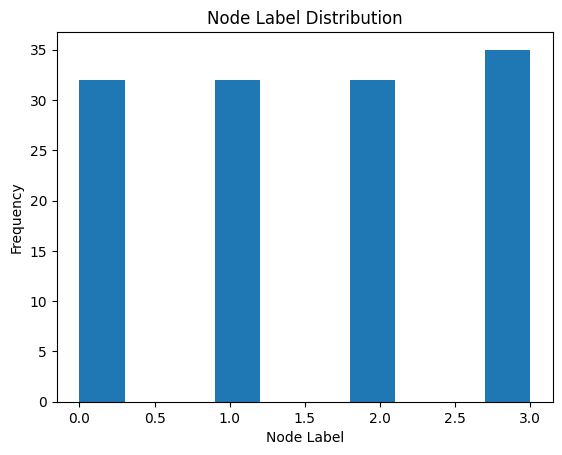

In [8]:
#Graficar la distribución de las clases a predecir.
plt.hist(data.y.tolist())
plt.xlabel('Node Label')
plt.ylabel('Frequency')
plt.title('Node Label Distribution')

Max degree: 81
Min degree: 1
Mean degree: 16.4
Median degree: 10.0
CPU times: user 81.4 ms, sys: 3.91 ms, total: 85.3 ms
Wall time: 84.7 ms


Text(0.5, 1.0, 'Degree Distribution')

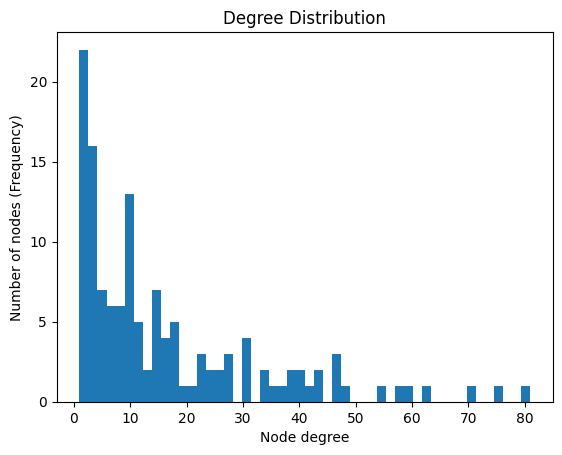

In [9]:
%%time
#Grafiquemos cuántos nodos hay por cada grado.
degrees = dict(G.degree())
degree_values = list(degrees.values())

print('Max degree:', max(degree_values))
print('Min degree:', min(degree_values))
print('Mean degree:', round(np.mean(degree_values), 2))
print('Median degree:', round(np.median(degree_values), 2))

plt.hist(degree_values, bins = 50)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes (Frequency)')
plt.title('Degree Distribution')

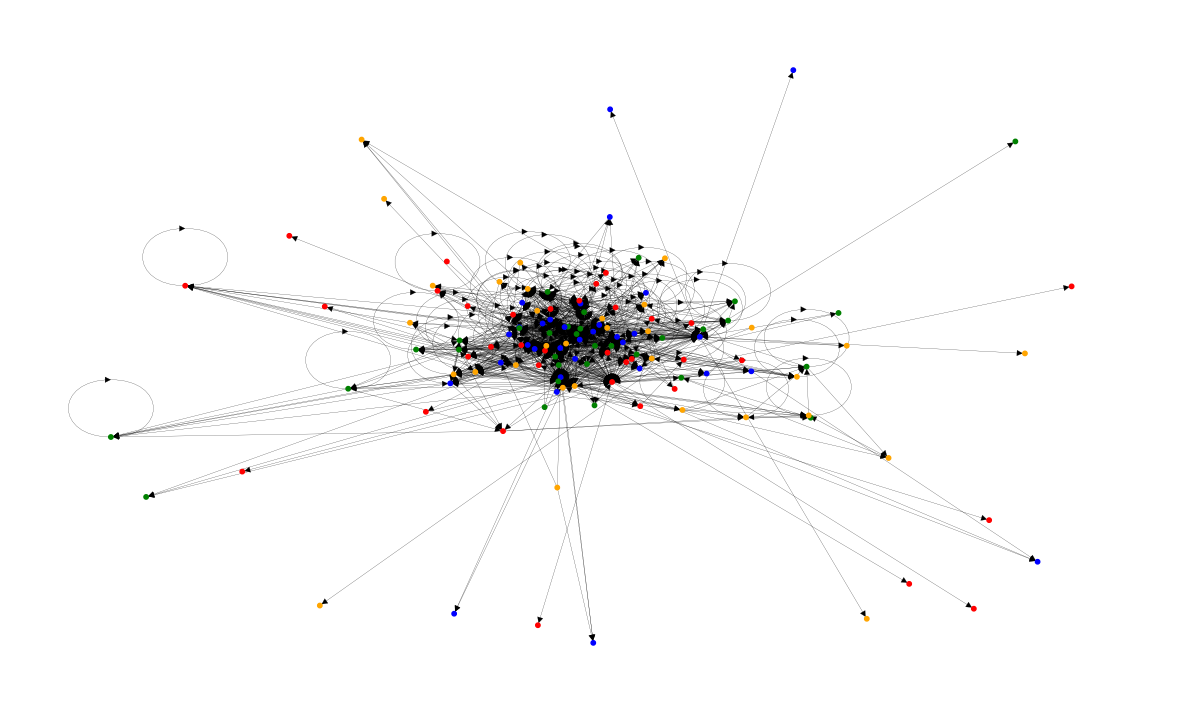

In [10]:
#Ahora, vamos a graficar/visualizar nuestro grafo.
color_map = []
for i in range(len(G.nodes)):
  if G.nodes[i]['y'] == 0:
    color_map.append('blue')
  elif G.nodes[i]['y'] == 1:
    color_map.append('green')
  elif G.nodes[i]['y'] == 2:
    color_map.append('orange')
  else:
    color_map.append('red')

plt.figure(figsize = (15, 9))
plt.axis("off")
nx.draw_networkx(G,
                 pos = nx.spring_layout(G, iterations = 15, seed = 25),
                 node_size = 10,
                 with_labels = False,
                 width = 0.15,
                 node_color = color_map
                 )

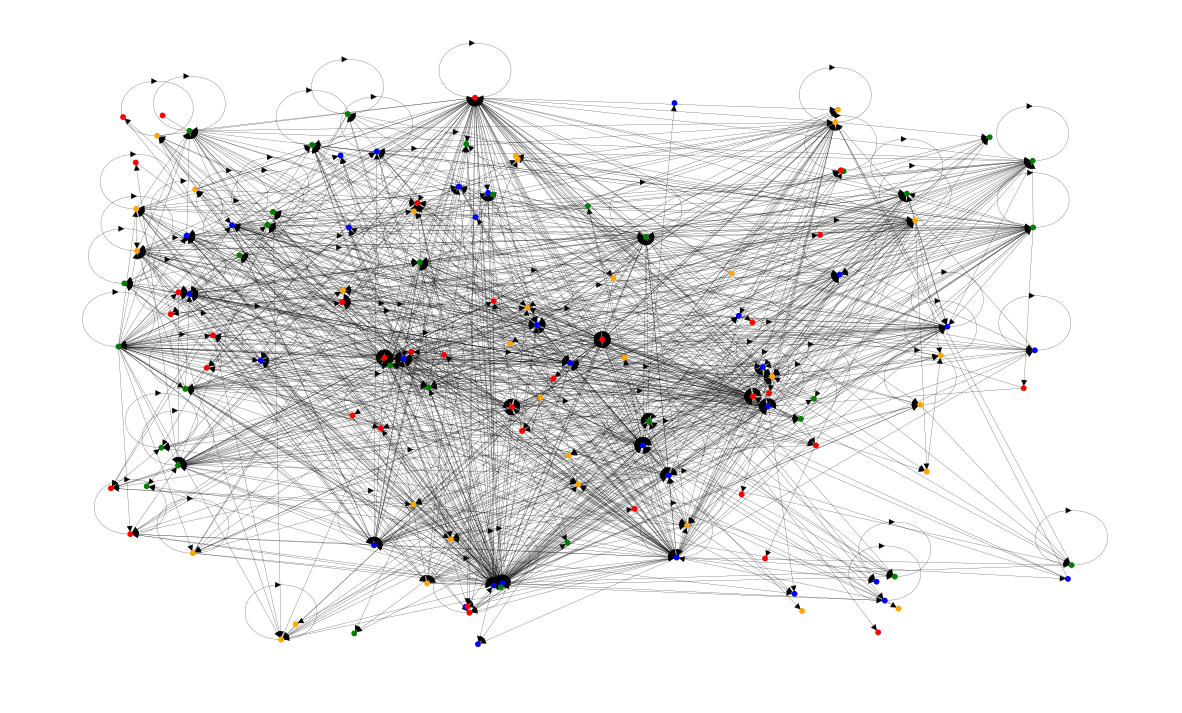

In [11]:
#Alternativa para graficar/visualizar nuestro grafo.
plt.figure(figsize = (15, 9))
plt.axis("off")
nx.draw_networkx(G,
                 pos = nx.random_layout(G, seed = 25),
                 node_size = 10,
                 with_labels = False,
                 width = 0.15,
                 node_color = color_map
                 )

##Construcción del modelo de clasificación:
Vamos a construir un modelo de clasificación cuyos predictores serán los embedding resultantes del modelo Node2Vec.

###Primer acercamiento:

In [12]:
#Modelo Node2Vec.
node2vec = Node2Vec(G, dimensions = 64, walk_length = 30, num_walks = 200, p = 2, q = 1, workers = 1)
model = node2vec.fit(window = 15, min_count = 1, batch_words = 4)

Computing transition probabilities:   0%|          | 0/131 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:07<00:00, 26.04it/s]


In [13]:
#Partición de los datos para entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(model.wv, data.y.tolist(), test_size = 0.3, random_state = 18, stratify = data.y.tolist())

In [14]:
#Entrenar clasificardor.
clf = RandomForestClassifier(random_state = 0)
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 32.50%


In [15]:
#Vamos a entrenar otro clasificador.
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 42.50%


In [16]:
#Vamos a entrenar otro clasificador.
clf = OneVsRestClassifier(LogisticRegression(max_iter = 300))
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 42.50%


###Segundo acercamiento:
Vamos a agregar el grado del nodo como variable predictora, junto al embedding.

In [17]:
#Construir array de variables predictoras.
x = np.append(model.wv.vectors, np.array(list(degrees.values())).reshape(-1, 1), axis = 1)

In [18]:
#Hacemos de nuevo la partición de los datos para entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(x, data.y.tolist(), test_size = 0.2, random_state = 18, stratify = data.y.tolist())

In [19]:
#Entrenar clasificador.
clf = RandomForestClassifier(random_state = 0)
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 33.33%


In [20]:
#Vamos a entrenar otro clasificador.
clf = OneVsRestClassifier(LogisticRegression(max_iter = 300))
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 40.74%


In [21]:
#Vamos a entrenar otro clasificador.
clf = OneVsRestClassifier(svm.SVC())
clf.fit(X_train, y_train)

#Evaluar el accuracy del modelo.
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_pred, y_test)*100:.2f}%')

Accuracy = 25.93%


###Elección del mejor modelo:

In [22]:
#Optimización de hiperparámetros.
def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['SVM', 'RandomForest', 'LogReg'])
    if regressor_name == 'SVM':
        svm_c = trial.suggest_float('svm_c', 1e-10, 1e10, log = True)
        regressor_obj = OneVsRestClassifier(svm.SVC(C = svm_c))
    elif regressor_name == 'LogReg':
        logreg_c = trial.suggest_float('logreg_c', 1e-10, 1e10, log = True)
        regressor_obj = OneVsRestClassifier(LogisticRegression(max_iter = 300, C = logreg_c))
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 40)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 40)
        regressor_obj = RandomForestClassifier(random_state = 0, max_depth = rf_max_depth, min_samples_split = rf_min_samples_split)

    X_train, X_test, y_train, y_test = train_test_split(model.wv, data.y.tolist(), test_size = 0.3, random_state = 18, stratify = data.y.tolist())

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [23]:
#Optimización de hiperparámetros.
study = optuna.create_study(direction='maximize', study_name = 'Hyperparam-Search')
study.optimize(objective, n_trials = 100)

[I 2023-10-22 23:23:03,730] A new study created in memory with name: Hyperparam-Search
[I 2023-10-22 23:23:03,763] Trial 0 finished with value: 0.35 and parameters: {'regressor': 'SVM', 'svm_c': 3.0269115318621667e-07}. Best is trial 0 with value: 0.35.
[I 2023-10-22 23:23:03,789] Trial 1 finished with value: 0.25 and parameters: {'regressor': 'LogReg', 'logreg_c': 9.658138273883892e-08}. Best is trial 0 with value: 0.35.
[I 2023-10-22 23:23:03,810] Trial 2 finished with value: 0.35 and parameters: {'regressor': 'SVM', 'svm_c': 276666973.03300023}. Best is trial 0 with value: 0.35.
[I 2023-10-22 23:23:03,828] Trial 3 finished with value: 0.45 and parameters: {'regressor': 'SVM', 'svm_c': 0.05099730635261935}. Best is trial 3 with value: 0.45.
[I 2023-10-22 23:23:03,998] Trial 4 finished with value: 0.375 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 27, 'rf_min_samples_split': 31}. Best is trial 3 with value: 0.45.
[I 2023-10-22 23:23:04,193] Trial 5 finished with value

In [24]:
#Mejor modelo y mejor hiperparámetros.
print('Mejor modelo:', study.best_params)
#Mejor accuracy.
print(f'Accuracy = {study.best_value*100:.2f}%')

Mejor modelo: {'regressor': 'SVM', 'svm_c': 0.05099730635261935}
Accuracy = 45.00%


In [25]:
#Optimización de hiperparámetros.
def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['SVM', 'RandomForest', 'LogReg'])
    if regressor_name == 'SVM':
        svm_c = trial.suggest_float('svm_c', 1e-10, 1e10, log = True)
        regressor_obj = OneVsRestClassifier(svm.SVC(C = svm_c))
    elif regressor_name == 'LogReg':
        logreg_c = trial.suggest_float('logreg_c', 1e-10, 1e10, log = True)
        regressor_obj = OneVsRestClassifier(LogisticRegression(max_iter = 10000, C = logreg_c))
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 40)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 40)
        regressor_obj = RandomForestClassifier(random_state = 0, max_depth = rf_max_depth, min_samples_split = rf_min_samples_split)

    X_train, X_test, y_train, y_test = train_test_split(x, data.y.tolist(), test_size = 0.2, random_state = 18, stratify = data.y.tolist())

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [26]:
#Optimización de hiperparámetros.
study = optuna.create_study(direction='maximize', study_name = 'Hyperparam-Search')
study.optimize(objective, n_trials = 100)

[I 2023-10-22 23:23:09,617] A new study created in memory with name: Hyperparam-Search
[I 2023-10-22 23:23:09,961] Trial 0 finished with value: 0.4074074074074074 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 17, 'rf_min_samples_split': 4}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-10-22 23:23:09,999] Trial 1 finished with value: 0.25925925925925924 and parameters: {'regressor': 'SVM', 'svm_c': 753.2226715519826}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-10-22 23:23:10,042] Trial 2 finished with value: 0.3333333333333333 and parameters: {'regressor': 'SVM', 'svm_c': 6461016150.004216}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-10-22 23:23:10,334] Trial 3 finished with value: 0.4074074074074074 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 10, 'rf_min_samples_split': 18}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-10-22 23:23:10,379] Trial 4 finished with value: 0.3333333333333333 and parameters: {'r

In [27]:
#Mejor modelo y mejor hiperparámetros.
print('Mejor modelo:', study.best_params)
#Mejor accuracy.
print(f'Accuracy = {study.best_value*100:.2f}%')

Mejor modelo: {'regressor': 'RandomForest', 'rf_max_depth': 8, 'rf_min_samples_split': 15}
Accuracy = 44.44%
